# C3M1: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Apply Binomial regression methods to real data.
2. Understand how to analyze and interpret binomial regression models.
3. Flex our math skills by determining whether certain distributions are members of the exponential family.

General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [2]:
# Load required libraries
library(tidyverse)
library(dplyr)
library(ggplot2)
library(gridExtra) # Subplot pack
library(RColorBrewer) # Color palette pack

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Problem 1: Binomial (Logistic) Regression

The National Institute of Diabetes and Digestive and Kidney Diseases conducted a study of 768 adult female Pima Indians living near Phoenix, AZ. The purpose of the study was to investigate the factors related to diabetes. 

*Before we analyze these data, we should note that some have raised ethical issues with its collection and popularity in the statistics and data science community. We should think seriously about these concerns. For example, Maya Iskandarani wrote a brief [piece](https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/) on consent and privacy concerns raised by this dataset. After you familarize yourself with the data, we'll then turn to these ethical concerns.*


First, we'll use these data to get some practice with GLM and Logistic regression.

In [3]:
# Load the data
pima = read.csv("pima.txt", sep="\t")
# Here's a description of the data: https://rdrr.io/cran/faraway/man/pima.html
head(pima)
# Check for the data type of pima
str(pima)

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


'data.frame':	768 obs. of  9 variables:
 $ pregnant : int  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose  : int  148 85 183 89 137 116 78 115 197 125 ...
 $ diastolic: int  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps  : int  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin  : int  0 0 0 94 168 0 88 0 543 0 ...
 $ bmi      : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ diabetes : num  0.627 0.351 0.672 0.167 2.288 ...
 $ age      : int  50 31 32 21 33 30 26 29 53 54 ...
 $ test     : int  1 0 1 0 1 0 1 0 1 1 ...


### 1. (a) Data Cleaning? What about Data Scrubbing? Data Sterilizing?

This is a real data set, which means that there's likely going to be gaps and missing values in the data. Before doing any modeling, we should inspect the data and clean it if necessary.

Perform simple graphical and numerical summaries of the data. Pay attention for missing or nonsensical values. Can you find any obvious irregularities? If so, take appropriate steps to correct these problems. In the markdown cell, specify what cleaning you did and why you did it.

Finally, split your data into training and test sets. Let the training set contain $80\%$ of the rows and the test set contain the remaining $20\%$.


In [4]:
## 1.1 Flag Irregularities Steps

# Design columns to convert
columns_to_convert = c("glucose", "diastolic", "triceps", "insulin")
pima_flag = pima #  # replicate pima as pima_flag

# Convert str into numeric
pima[columns_to_convert] = lapply(pima_flag[columns_to_convert], function(x) {
  if (is.factor(x)) {
    as.numeric(as.character(x))
  } else {
    as.numeric(x)
  }
})

# Check for the data type of converted columns
str(pima_flag[columns_to_convert])

# Replace nonsensical values of NA
# Negative pregnant shows a mistake.
pima_flag$pregnant[pima_flag$pregnant < 0] = NA
# Negative test result shows a mistake.
pima_flag$test[pima_flag$test < 0] = NA
# Blood glucose levels should normally be non-negative. 
pima_flag$glucose[pima_flag$glucose <= 0] = NA    
# Diastolic blood pressure should be non-negative. 
pima_flag$diastolic[pima_flag$diastolic <= 0] = NA    
# Triceps skinfold thickness should be non-negative. 
pima_flag$triceps[pima_flag$triceps <= 0] = NA    
# Insulin levels should be non-negative.
pima_flag$insulin[pima_flag$insulin <= 0] = NA     
# BMI should be non-negative.
pima_flag$bmi[pima_flag$bmi <= 0] = NA     
# Values of diabetes should be non-negative.
pima_flag$diabetes[pima_flag$diabetes <= 0] = NA      
# age should be non-negative.
pima_flag$age[pima_flag$age <= 0] = NA     

head(pima_flag)
#head(pima)

# Check for missing values in pima pima_flag
sapply(pima, function(x) sum(is.na(x)))
sapply(pima_flag, function(x) sum(is.na(x)))

'data.frame':	768 obs. of  4 variables:
 $ glucose  : int  148 85 183 89 137 116 78 115 197 125 ...
 $ diastolic: int  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps  : int  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin  : int  0 0 0 94 168 0 88 0 543 0 ...


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,NA,33.6,0.627,50,1
2,1,85,66,29,NA,26.6,0.351,31,0
3,8,183,64,NA,NA,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,NA,NA,25.6,0.201,30,0


pregnant   glucose diastolic   triceps   insulin       bmi  diabetes       age 
        0         0         0         0         0         0         0         0 
     test 
        0

pregnant   glucose diastolic   triceps   insulin       bmi  diabetes       age 
        0         5        35       227       374        11         0         0 
     test 
        0

In [5]:
# Numerical Summary
summary(pima_flag)

    pregnant         glucose        diastolic         triceps     
 Min.   : 0.000   Min.   : 44.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 64.00   1st Qu.:22.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :29.00  
 Mean   : 3.845   Mean   :121.7   Mean   : 72.41   Mean   :29.15  
 3rd Qu.: 6.000   3rd Qu.:141.0   3rd Qu.: 80.00   3rd Qu.:36.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
                  NA's   :5       NA's   :35       NA's   :227    
    insulin            bmi           diabetes           age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0780   Min.   :21.00  
 1st Qu.: 76.25   1st Qu.:27.50   1st Qu.:0.2437   1st Qu.:24.00  
 Median :125.00   Median :32.30   Median :0.3725   Median :29.00  
 Mean   :155.55   Mean   :32.46   Mean   :0.4719   Mean   :33.24  
 3rd Qu.:190.00   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200   Max.   :81.

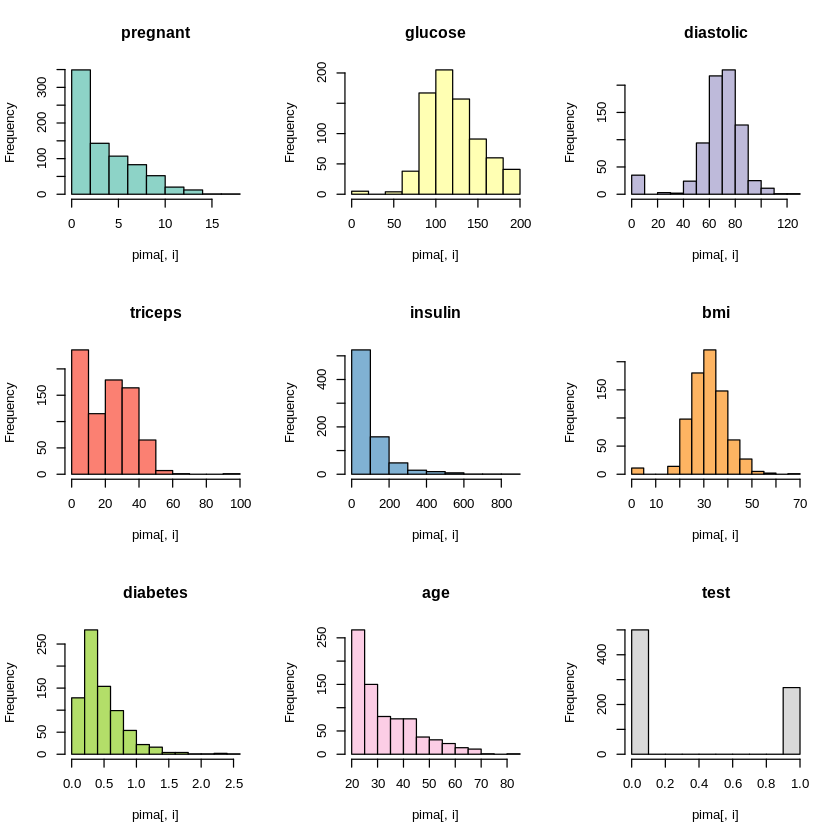

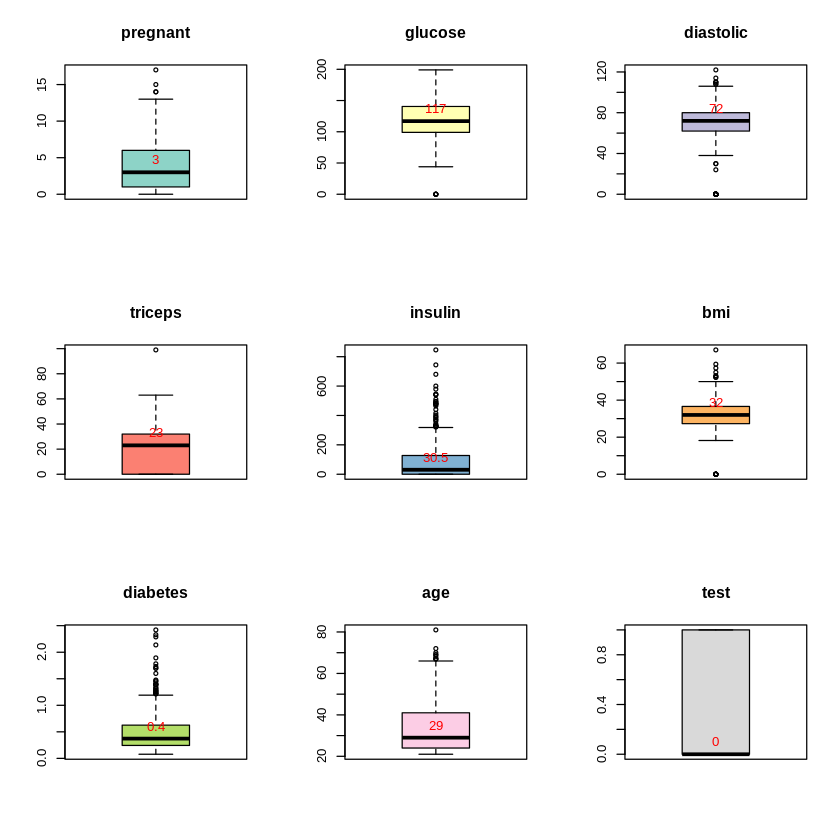

In [6]:
# Data Visulization

# Graphical summary
# Set color theme
set3_colors = brewer.pal(9, "Set3")

par(mfrow=c(3,3))

# Plot histograms to show weirdness
for (i in 1:9) {
    hist(pima[,i], col = set3_colors[i], main = names(pima)[i])
}
par(mfrow=c(1,1))

par(mfrow=c(3,3))

# Plot boxplot to show weirdness
for (i in 1:9) {
    boxplot(pima[,i], col = set3_colors[i], main = names(pima)[i])
    median_value = median(pima[,i], na.rm = TRUE)  # Add median value as text
    text(x = 1, y = median_value, labels = round(median_value, 1), 
         pos = 3, cex = 1, col = "Red")
}
# Reset plotting area to default
par(mfrow=c(1,1))

Warning message:
“Removed 652 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 652 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 652 rows containing non-finite values (stat_summary).”


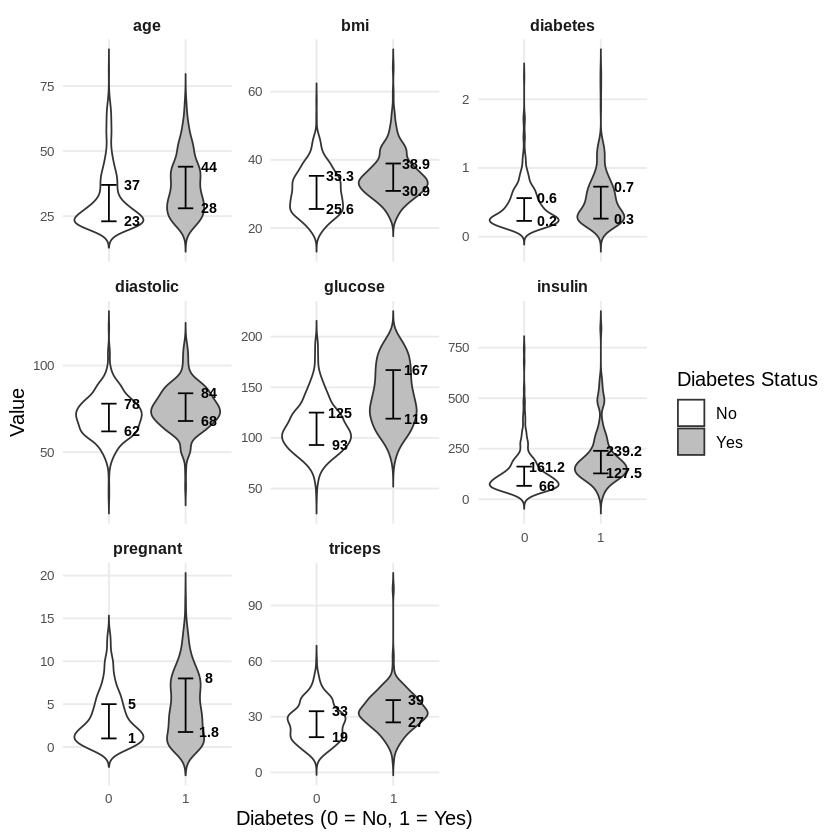

In [9]:
# Convert data from wide to long format
pima_longdata = pima_flag %>%
  pivot_longer(cols = c(pregnant, glucose, diastolic, triceps, insulin, bmi, diabetes, age), 
               names_to = "Variable", values_to = "Value")


# Plot violin graphs to view overall data outline
ggplot(pima_longdata, aes(x = factor(test), y = Value, fill = factor(test))) +
  geom_violin(trim = FALSE) +
  facet_wrap(~ Variable, scales = "free_y", ncol = 3 ) +  # Split-plane display, one subplot per variable
  labs(x = "Diabetes (0 = No, 1 = Yes)", 
       y = "Value", 
       fill = "Diabetes Status") +  # Set labels
  scale_fill_manual(values = c("0" = "white", "1" = "grey"), 
                    labels = c("No", "Yes")) +  
  theme_minimal(base_size = 12) +
  theme(legend.position = "right",  # Place legend on the right
        strip.text = element_text(hjust = 0.5, face = "bold"),  # Bold facet labels
        axis.text = element_text(size = 8),  
        panel.grid.minor = element_blank()) + 

# Add Q1 and Q3 as vertical lines
  stat_summary(fun.data = function(y) {
      Q1 = quantile(y, 0.25, na.rm = TRUE)
      Q3 = quantile(y, 0.75, na.rm = TRUE)
    return(data.frame(ymin = Q1, ymax = Q3)) # Compute Q1 and Q3
  }, geom = "errorbar", width = 0.2, color = "black") + # Plot vertical lines for Q1 and Q3 

# Add labels for Q1 and Q3
  stat_summary(fun.data = function(y) {
      Q1 = quantile(y, 0.25, na.rm = TRUE)
      Q3 = quantile(y, 0.75, na.rm = TRUE)
    return(data.frame(y = c(Q1, Q3), label = round(c(Q1, Q3), 1)))
  }, geom = "text", aes(label = ..label..), position = position_nudge(x = 0.3), size = 3, fontface = "bold")


### Exploratory Data Analysis (EDA) 

There are 9 variables and 768 samples, with no missing data overall (the study should suspect that the data has been filled in by this point) and no duplicates. The data types were 8 numeric and 1 boolean.

#### Factors that need to delete NA

- **Pregnancy**: We observe that 14.5% of the samples (111 cases) have a value of 0 for this feature, but considering the real-world context, it's likely that some women in the dataset have 0 pregnancies. Since the dataset doesn't emphasize specific conditions like pregnancy history, we can disregard the system's warning. There are no missing or extreme values; the data ranges from 0 to 17 pregnancies, with a mean of about 4.  According to the box plot, we calculate the upper limit value: Q3+1.5IQR=6+1.5x5=13.5, values above 13 should be flagged as unlimited values for processing.

The data shows a significant deviation in the relationship between diabetes and pregnancy. Diabetes cases are notably higher among those with 5 to 10 pregnancies compared to non-diabetes cases.


- **Blood glucose levels**: Glucose content shows no missing or limit values. There are 5 samples with a value of 0, accounting for 0.7%. Given that glucose cannot be 0 in the human body, this is likely due to manual entry. Numerical summary shows that the maximum value is 199. According to the box plot,the lower limit value: Q1-1.5IQR= 99 - 1.5 * 41.25 = 37.125. Only 5 samples fall below this, so they are set as NA. The upper limit is 202.125, but since the maximum value is 199, no further action is taken statistically.

The violin figure shows that post-meal glucose levels in the non-diseased group range from 50 to 160, mostly in (93.5,125.5), while in the diseased group, they range from 100 to 200, concentrated in (119,168). Glucose levels in the diseased group are 30% to 60% higher, with significant variability.

- **Diastolic blood pressure**: There were no missing or unlimited data, but 35 samples had a value of 0, accounting for 4.6%. In reality, normal individuals cannot have a blood pressure of 0, so these values need adjustment. Using a traditional box plot to infer outliers, the lower limit is 35 and the upper limit is 107. It's noted that, based on the data, the maximum value of 122 is plausible. Therefore, the upper limit is not adjusted, but the values of 0 are set as NA.

The violin figure shows that the overall distribution of blood pressure is similar between those with and without the disease, comparing with normal individual, concentrated in (62,78) diseased group tend to have slightly higher blood pressure, mostly in (68,84).


- **BMI**: BMI data has no missing or unlimited values, but 11 entries are 0, accounting for 1.4%, likely due to manual filling. The minimum is 0, and the maximum is 67.1. Since BMI can vary widely based on individual differences, the maximum value of 67.1 is considered normal. Therefore, the 0 values are set as NA.

The Violin figure shows that most diseased individuals have a BMI around 26, ranging from (25.9, 35.4), while those with the disease have BMI values around 33, ranging from (30.9,38.5). The BMI distribution for the diseased is about 13% higher than for the non-diseased group.

- **DiabetesPedigreeFunction (DPF)**：DPF has no missing or 0 values, and no restrictions. Outlier analysis using a box plot set the lower limit to 0, as values below 0 are not possible. The upper limit was calculated as 1.2, based on statistical data, with 1.2 used as the threshold since the upper limit cannot be precisely determined. 

The Violin figure shows that data distribution between whether or not the disease and DPF varies greatly. The DPF of the non-diseased population is mainly concentrated in (0.1,0.6), while the DPF of the diseased population is mainly distributed in (0.3,0.7), and most of the patients have a slightly higher DPF value.

- **Age**: Age has no missing or 0 values. And the minimum value is 21 and maximum value is 81, which are within the normal range, so this feature is no in need of procession.

From the violin figure, the data of the non-diseased population is mainly distributed between the ages of 22 to 36 years old, while the diseased are mainly distributed between the ages of 28 to 45 years old, and the diseased are mainly concentrated in the age of 35 years old, and the non-diseased are mainly concentrated in the age of ah 25 years old. The preliminary judgment is that there is a correlation between illness and age.

These factors only have small number of nonsensical values and irregularities so it will not cause too much information loss if I directly delete the rows that contain with these irregularities.

#### Factors that need to preserve NA

- **Triceps skinfold thickness**: There are no missing or unlimited values, but 227 samples have a value of 0, accounting for 29.6% of the total. Since normal individuals cannot have 0 subcutaneous fat thickness, these 0 values likely require manual correction. The minimum value is 0, and the maximum is 99, with no need for abnormal processing of the maximum value. To avoid skewing the data, the 0 values are replaced with NA.

The violin figure shows that triceps skinfold thickness in diseased individuals is mainly in (27,39), while in non-diseased individuals it range in (10,33). The non-diseased group shows more variance, while the diseased group is more concentrated.

- **Insulin(Serum insulin level 2 hours after meal)**: There are no missing values or restrictions, but 374 samples have a value of 0, making up 48.7% of the data. Since normal serum insulin levels should not be 0 two hours after a meal, these 0 values are outliers and set as NA. The minimum value is 0 and the maximum is 846. Howvewer, due to the high proportion of 0 values, using a violin plot may result in a biased, so the maximum value remains unflagged for now.

The violin figure shows that diseased group had a significant phenomenon of insulin resistance after a meal. Their insulin level is mainly in (127.5,239.2), non-diseased individuals it range in (66.0,163.8). 

There are lot of 0 values in `Triceps` and `Insulin`, these two factors show a great dominance on the disease in the violin plot excluding NA, removing these records would **substantially reduce the sample size**, so I decided to preserve these NA.

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35.0,106.25,33.6,0.627,50,1
2,1,85,66,29.0,154.25,26.6,0.351,31,0
3,8,183,64,23.3,126.25,23.3,0.672,32,1
4,1,89,66,23.0,94.00,28.1,0.167,21,0
5,0,137,40,35.0,168.00,43.1,2.288,33,1
6,5,116,74,26.9,89.25,25.6,0.201,30,0


pregnant   glucose diastolic   triceps   insulin       bmi  diabetes       age 
        0         0         0         0         0         0         0         0 
     test 
        0

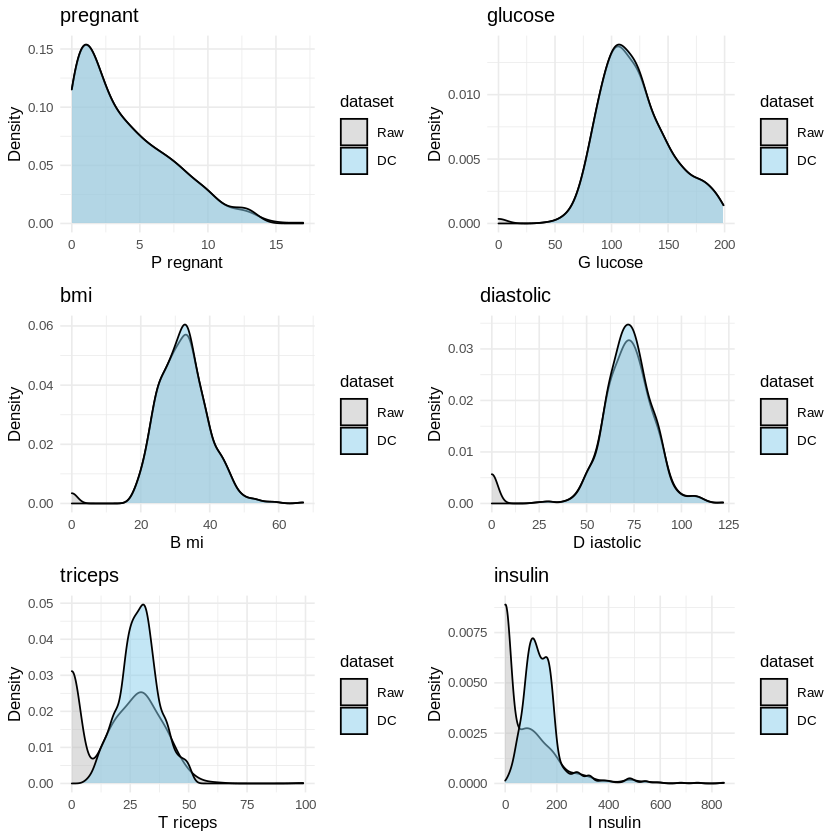

In [8]:
## 1.3 Data Cleaning Steps

pima_clean = pima_flag  

# 1. Process `pregnant`, setting any values greater than 13 to 13
pima_clean$pregnant[pima_clean$pregnant > 13] = 13

# 2. Process `glucose`, replace 0 values with median
pima_clean$glucose[is.na(pima_clean$glucose)] = median(pima_clean$glucose, na.rm = TRUE)

# 3. Process `bmi`, replace 0 values with the medians.
pima_clean$bmi[is.na(pima_clean$bmi)] = median(pima_clean$bmi, na.rm = TRUE)

# 4. Process `diastolic`, using regression imputation method

set.seed(123) # Set seed for reproducibility
train_size = floor(0.8 * nrow(pima_clean))   # define the size of training set (80%)
train_indices = sample(seq_len(nrow(pima_clean)), size = train_size)  # Randomly pick up rows for sample

# Split the data into training and testing sets
train = pima_clean[train_indices, ]
test = pima_clean[-train_indices, ]

# Create linear Regression model
lm_model = lm(diastolic ~ pregnant + glucose + bmi + diabetes + age, #
               data = train)

# Predicted values in `diastolic`
predicted_diastolic = predict(lm_model, newdata = test)

# Replace 0 values with predicted values
pima_clean$diastolic[is.na(pima_clean$diastolic)] = predicted_diastolic[is.na(test$diastolic)]

# 5. Process `triceps` using random imputation method
# Step 1: Calculate Q1 and Q3 for non-NA values in triceps
triceps_non_na = pima_clean$triceps[!is.na(pima_clean$triceps)]
triceps_q1 = quantile(triceps_non_na, 0.25, na.rm = TRUE)
triceps_q3 = quantile(triceps_non_na, 0.75, na.rm = TRUE)

# # Step 2: Perform random imputation within the range [Q1, Q3]
set.seed(123)  # For reproducibility
pima_clean$triceps[is.na(pima_clean$triceps)] = sample(seq(triceps_q1, triceps_q3, by = 0.1), 
                                                      sum(is.na(pima_clean$triceps)), replace = TRUE)

# Further IQR check and process outliers
triceps_iqr = IQR(pima_clean$triceps, na.rm = TRUE)
triceps_upper = quantile(pima_clean$triceps, 0.75, na.rm = TRUE) + 1.5 * triceps_iqr
pima_clean$triceps[pima_clean$triceps > triceps_upper] = triceps_upper

# 6. Process Insulin using targeted random imputation
# Step 1: Calculate Q1 and Q3 for non-NA values in insulin
insulin_non_na = pima_clean$insulin[!is.na(pima_clean$insulin)]
insulin_q1 = quantile(insulin_non_na, 0.25, na.rm = TRUE)
insulin_q3 =quantile(insulin_non_na, 0.75, na.rm = TRUE)

# Step 2: Perform random imputation within the range [Q1, Q3]
set.seed(123)  # For reproducibility
pima_clean$insulin[is.na(pima_clean$insulin)] = sample(seq(insulin_q1, insulin_q3, by = 1), 
                                                        sum(is.na(pima_clean$insulin)), replace = TRUE)

# The cleaned data with imputed insulin values
head(pima_clean)


# The cleaned data is now stored in pima_clean
sapply(pima_clean, function(x) sum(is.na(x)))
 
       
# Plotting data
# Step 1: Add a 'dataset' column to both original and cleaned data
pima$dataset = "Raw"  
pima_clean$dataset = "DC"  # DC data set

# Step 2: List of variables to plot
variables = c("pregnant", "glucose", "bmi", "diastolic", "triceps", "insulin")

# Step 3: Create density plots for each variable in a loop
plot_list = lapply(variables, function(var) {
  combined_data = rbind(
    data.frame(value = pima[[var]], dataset = "Raw"),
    data.frame(value = pima_clean[[var]], dataset = "DC")
  )
  
  ggplot(combined_data, aes(x = value, fill = dataset)) +
    geom_density(alpha = 0.5) +
    labs(title = paste(var),
         x = paste(toupper(substring(var, 1, 1)), substring(var, 2)), 
         y = "Density") +
    theme_minimal(base_size = 10) +
    scale_fill_manual(values = c("Raw" = "grey", "DC" = "skyblue")) +
    theme(legend.position = "right")
})

# Step 4: Arrange all plots in a grid (3x2)
grid.arrange(grobs = plot_list, nrow = 3, ncol = 2)

# Split the data into training and testing sets       
set.seed(123) 
train_size = floor(0.8 * nrow(pima_clean))   
train_indices = sample(seq_len(nrow(pima_clean)), size = train_size)  
       
train = pima_clean[train_indices, ]
test = pima_clean[-train_indices, ]

### Data Cleaning (DC) Analysis

1. **Pregnancies**: Based on EDA results, the range should be 0–13. Values greater than 13 were capped at 13.
2. **Glucose**: EDA revealed 5 samples with anomalous 0 values, while no upper limit anomalies were detected. These values were corrected using median imputation, considering the data distribution.
3. **BMI**: EDA showed 11 samples with 0 values as anomalies. No upper limit anomalies were detected. Median imputation was used for correction.
4. **Diastolic Blood Pressure**: EDA identified 35 samples with 0 values. The approach used here is regression imputation. The dataset was split into two sets (80% training, 20% test), and five features (Pregnancies, Glucose, BMI, Diabetes, Age) were selected for regression. These features were chosen because:
   - They had been cleaned and were usable.
   - Outcome was the target prediction variable, and including BloodPressure might affect the final prediction.
   - Other features had not been cleaned yet, which could impact the results. The distribution after imputation showed a more normal distribution.
5. **Triceps Skinfold Thickness**: EDA revealed 227 samples with 0 values, representing nearly 30% of the data. Targeted random imputation was applied, with improvements:
   - Calculated the 1st and 3rd quartiles of non-zero data.
   - Random sampling within this range with replacement.
Compared to median imputation—which caused large peaks—and predictive imputation—which significantly altered the distribution—this method was more effective and resulted in a near-normal distribution.

6. **Insulin**: EDA showed 374 samples with 0 values, nearly half of the data. As well as `triceps`, targeted random imputation within the range [Q1, Q3] was applied. Compared to median imputation—which caused large peaks—and predictive imputation—which significantly altered the distribution—this method was more effective and resulted in a near-normal distribution.



| Feature                    | Discovered Issue                           | Exploration Method | Cleaning Solution           |
|----------------------------|--------------------------------------------|--------------------|-----------------------------|
| Pregnancies                 | Exceeded IQR upper limit                   | IQR method         | Replace with upper limit    |
| Glucose                     | Exceeded IQR upper limit                   | IQR method         | Replace with median         |
| BloodPressure               | 1. 0 values shouldn't exist                | Expert experience  | Model prediction            |
|                            | 2. Exceeded IQR upper limit                |                    | Random imputation method    |
| SkinThickness               | 1. 0 values shouldn't exist                | Expert experience  | Targeted random imputation  |
|                            | 2. Exceeded IQR upper limit                |                    |                             |
| Insulin                     | Calculated                                 | -                  | Replace with median         |
| BMI                         | No issues found                            | -                  |                             |
| DiabetesPedigreeFunction    | No issues found                            | -                  |                             |
| Age                         | No issues found                            | -                  |                             |

After applying the targeted random sampling method to repair the data, we found that the overall data distribution became closer to a normal distribution, and the repair method effectively handled the detected anomalies. However, there remains a significant amount of long-tail data, which will require further processing through feature engineering.

### 1. (b) Initial GLM modelling


Our data is clean and we're ready to fit! What kind of model should we use to fit these data? Notice that the `test` variable is either $0$ or $1$, for whether the individual tested positive for diabetes. Because `test` is binary, we should use logistic regression (which is a kind of binomial regression).

Fit a model with `test` as the response and all the other variables as predictors. Can you tell whether this model fits the data?


Call:
glm(formula = test ~ pregnant + glucose + diastolic + triceps + 
    insulin + bmi + diabetes + age, family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4721  -0.7162  -0.4017   0.6906   2.3614  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.963444   0.898243  -9.979  < 2e-16 ***
pregnant     0.118201   0.036630   3.227  0.00125 ** 
glucose      0.039291   0.004425   8.880  < 2e-16 ***
diastolic   -0.011623   0.009569  -1.215  0.22449    
triceps      0.002608   0.014447   0.181  0.85672    
insulin     -0.001421   0.001202  -1.183  0.23699    
bmi          0.093596   0.019941   4.694 2.68e-06 ***
diabetes     0.711705   0.319993   2.224  0.02614 *  
age          0.014008   0.010572   1.325  0.18519    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 796.42  on 613  degrees of freedom
Residual d

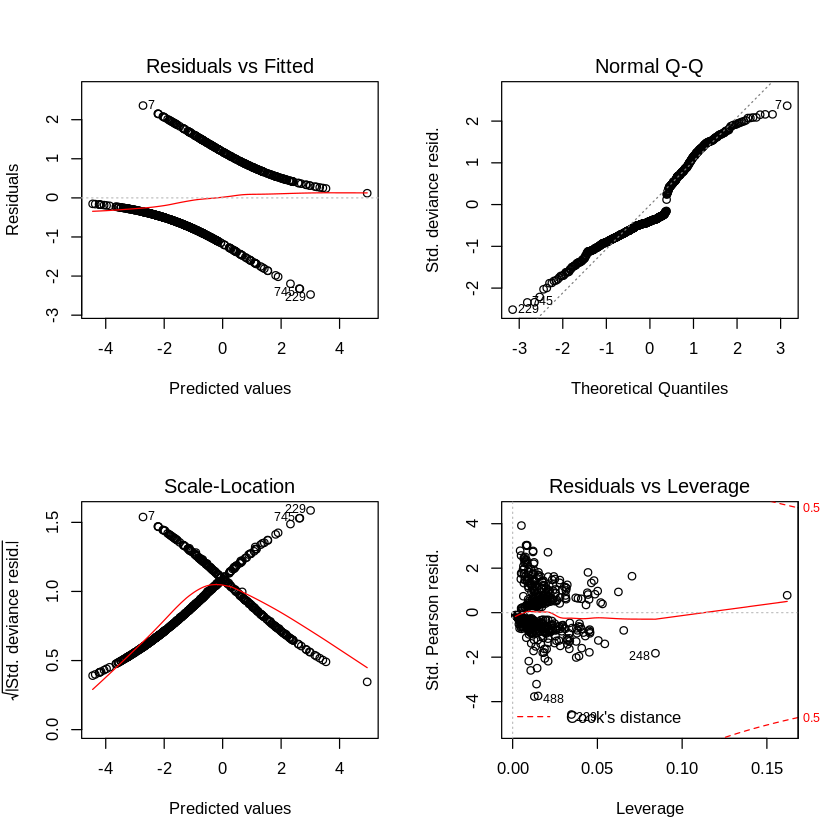

In [34]:
# Fit the logistic regression model
GLMmodel = glm(test ~ pregnant+glucose+diastolic+triceps+insulin+bmi+diabetes+age, 
             data = train, 
             family = binomial)

# Summary of the model
summary(GLMmodel)

par(mfrow = c(2,2)); plot(GLMmodel)


#### **Model Fit Evaluation:**

1. **Residuals vs Fitted Plot**: 
   - Shows a pattern, indicating the model might not fully capture the relationship between the predictors and the outcome.
   

2. **Normal Q-Q Plot**: 
   - Residuals mostly follow the line, with some deviations at the extremes. This suggests mild departures from normality but isn't a major issue for logistic regression.
   

3. **Scale-Location Plot**: 
   - Suggests possible non-constant variance (heteroscedasticity), which might indicate the need for model adjustments.
   

4. **Residuals vs Leverage Plot**: 
   - A few points have high leverage, meaning they may disproportionately affect the model. Investigating these points might improve model robustness.

#### **Summary Statistics**:

- **Significant Predictors**: Variables like `glucose`, `pregnant`, and `bmi` are significant predictors of the outcome.
- **Non-Significant Predictors**: `diastolic`, `triceps`, `insulin`, and `age` are not significant, suggesting they have limited impact in this model.
- **Deviance**: The model reduces deviance but leaves a lot of unexplained variation, suggesting room for improvement.


The model is moderately well-fitted, but there are signs of issues like non-linearity, influential outliers, and non-significant predictors. Further investigation and potential model refinements may be needed to improve its accuracy.


### 1. (c) Remember Bayes

A quick analytical interlude.

Is diastolic blood pressure significant in the regression model? Do women who test positive have higher diastolic blood pressures? Explain the distinction between the two questions and discuss why the answers are only apparently contradictory.

In [32]:
# Get a summary of the model
lm_diastolic = lm(test ~ diastolic,data = train)
summary(lm_diastolic)


Call:
lm(formula = test ~ diastolic, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5857 -0.3643 -0.2905  0.5988  0.8448 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.090829   0.116167  -0.782 0.434585    
diastolic    0.006150   0.001592   3.863 0.000124 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4726 on 612 degrees of freedom
Multiple R-squared:  0.0238,	Adjusted R-squared:  0.0222 
F-statistic: 14.92 on 1 and 612 DF,  p-value: 0.0001241


#### Why Diastolic is Insignificant in the GLM but Higher in Positive-Tested Women:

- **Explanation for GLM Model Insignificance:**
   In the GLM model, the insignificance of the `diastolic` coefficient can be explained by the fact that multiple predictors (e.g., glucose, bmi) are contributing to the outcome. When these variables are included in the model, their relationships may overshadow the contribution of diastolic, a phenomenon known as **multicollinearity** or **variable competition**. Essentially, other variables (like glucose) explain the outcome so well that diastolic’s marginal contribution diminishes, leading to its insignificance in the GLM.

   However, this does not mean that diastolic is irrelevant; rather, its independent effect is reduced when accounting for the other variables.


- **Explanation for Higher Diastolic in Positive-Tested Women:**
   This phenomenon reflects **conditional probability**. When considering diastolic and the test result alone (without other variables), this indicates that diastolic tends to be higher in the positive group. This is a **posterior effect** in a simplified model — given that a woman tested positive, her diastolic pressure is likely to be higher on average.

#### Mathematical Perspective:
- **Prior Probability:** Before modeling, we might believe that higher diastolic pressure is associated with diabetes — this is our prior belief.
  
- **Posterior Probability:** When incorporating other variables (like glucose and bmi) into the GLM, we update our prior beliefs. The contribution of diastolic may decrease because other variables better explain the outcome. As a result, its independent effect is diminished, leading to its insignificance in the GLM model.

This reflects the Bayesian principle of **updating beliefs** based on new data. Even though diastolic might show a clear association with diabetes on its own, its marginal contribution becomes negligible when considering the combined effects of all variables.

#### Simplified Conclusion:
- In the GLM, `diastolic`'s contribution is overshadowed by other variables, making it insignificant.
- In the lm model, `diastolic` shows a clear association with the outcome because it's the only variable being considered.



### 1. (d) GLM Interpretation

We've seen so many regression summaries up to this point, how is this one different from all the others? Well, to really understand any model, it can be helpful to loop back and plug the fitted results back into the model's mathematical form.

Explicity write out the equation for the binomial regression model that you fit in (b). Then, in words, explain how a $1$ unit change of `glucose` affects `test`, assuming all other predictors are held constant.

In [36]:
# Get a summary of the model
beta_glucose = coef(GLMmodel)["glucose"]
beta_glucose

glucose 
0.03929137

#### Equation for the Binomial Regression Model:

The binomial logistic regression model fitted in (b) can be written in the following form:

<div style="text-align: center;">
$$
\text{logit}(\hat p) = \ln\left(\frac{\hat p}{1 - \hat p}\right) = \hat \beta_0 + \hat \beta_1 \cdot \text{pregnant} + \hat \beta_2 \cdot \text{glucose} + \hat \beta_3 \cdot \text{diastolic} + \hat \beta_4 \cdot \text{triceps} + \hat \beta_5 \cdot \text{insulin} + \hat \beta_6 \cdot \text{bmi} + \hat \beta_7 \cdot \text{diabetes} + \hat \beta_8 \cdot \text{age}
$$
</div>

Where:
- $\hat p$ is the probability that $\text{test} = 1$, meaning the individual tests positive for diabetes.
- $\hat \beta_0$ is the intercept.
- $\hat \beta_1, \hat \beta_2, \dots, \hat \beta_8$ are the estimated coefficients for the respective predictor variables (`pregnant`, `glucose`, `diastolic`, `triceps`, `insulin`, `bmi`, `diabetes`, and `age`).


#### How a 1 Unit Change in 'glucose' Affects Test (Holding Other Variables Constant):

In the logistic regression model, the coefficient $\beta_2$ represents the effect of glucose on the log-odds of testing positive for diabetes.

From the regression equation:


<div style="text-align: center;">
$$\text{logit}(\hat p) = \hat \beta_2 \cdot \text{glucose} + \text{other terms} $$
</div>

- A 1 unit increase in `glucose` corresponds to an increase of $\hat \beta_2$ in the log-odds of testing positive for diabetes. In (b)'s model, $\hat \beta_2$ is **0.038044**.

- In words, <u><b>for every 1 unit increase in glucose, the log-odds of testing positive for diabetes increases by 0.038044</b></u>, assuming all other predictors remain constant.

To translate this into an effect on the probability of testing positive, you can exponentiate the coefficient:

<div style="text-align: center;">
$$\text{Odds Ratio} = e^{\hat \beta_2} = e^{0.038044} \approx 1.0388$$
</div>
    
- This means that for each 1 unit increase in glucose, the **odds of testing positive for diabetes increase by about 3.88%**, holding all other variables constant.


### 1. (e) GLM Prediction

One of the downsides of Logistic Regression is that there isn't an easy way of evaulating the goodness of fit of the model without predicting on new data. But, if we have more data to test with, then there are many methods of evaluation to use. One of the best tools are confusion matrices, which (despite the name) are actually not that hard to understand.

A confusion matrix compares the predicted outcomes of a Logistic Regression Model (or any classification model) with the actual classifications. For binary classification, it is a $2 \times 2$ matrix where the rows are the models' predicted outcome and the columns are the actual classifications. An example is displayed below.

|  | True | False |  
| --- | --- | --- |
| 1 | 103 | 37 |  
| 0 | 55  | 64 |  

In the example, we know the following information:
* The [1,1] cell is the number of datapoints that were correctly predicted to be $1$. The value (103) is the number of True Positives (TP). 
* The [2,2] cell is the number of datapoints that were correctly predicted to be $0$. The value is the number of True Negatives (TN).
* The [1, 2] cell is the number of datapoints that were predicted to be $1$ but where actually $0$. This is the number of False Positives (FP), also called Type I error. In the context of our diabetes dataset, this would mean our model predicted that the person would have diabetes, but they actually did not.
* The [2, 1] cell is the number of datapoints that were predicted to be $0$ but where actually $1$. This is the number of False Negatives (FN), also called Type 2 error. In the context of our diabetes dataset, this would mean our model predicted that the person would not have diabetes, but they actually did have diabetes.

Use your model to predict the outcomes of the test set. Then construct a confusion matrix for these predictions and display the results.

In [22]:
# Make predictions on the test set
predicted_prob = predict(GLMmodel, newdata = test, type = "response")
predicted_class = ifelse(predicted_prob > 0.5, 1, 0)  # Convert probabilities to binary outcomes

# Construct the confusion matrix
actual_class = test$test
confusion_matrix = table(Predicted = predicted_class, Actual = actual_class)

# Display the confusion matrix
confusion_matrix

         Actual
Predicted  0  1
        0 89 23
        1 13 29


|             | Actual 0 | Actual 1 |
|-------------|----------|----------|
| Predicted 0 | 89       | 23       |
| Predicted 1 | 13       | 29       |


This matrix shows:

- *True Negatives (TN) [0,0] = 89*: This model correctly predicted 46 individuals as not having diabetes (0), and they indeed did not have diabetes.
  
- *False Negatives (FN) [0,1] = 23*: This model predicted 10 individuals as not having diabetes (0), but they actually did have diabetes. **This is a Type II error.**

- *False Positives (FP) [1,0] = 13*: This model predicted 6 individuals as having diabetes (1), but they did not have diabetes. **This is a Type I error.**

- *True Positives (TP) [1,1] = 29*: This model correctly predicted 10 individuals as having diabetes (1), and they indeed had diabetes.


### 1. (f) Evaluation Statistics

Using the four values from the confusion matrix, we can construct evaulation statistics to get a numerical approximation for our model's performance. Spend some time researching accuracy, precision, recall and F score. 

Calculate these values for your model's predictions on the test set. Clearly display your results. How well do you think your model fits the data?

In [24]:
# Values from the confusion matrix
TP = 89  # True Positives
TN = 23  # True Negatives
FP = 13   # False Positives
FN = 29  # False Negatives

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall
recall = TP / (TP + FN)

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Display the results
accuracy
precision
recall
f1_score


[1] 0.7272727

[1] 0.872549

[1] 0.7542373

[1] 0.8090909

### Model Fit Evaluation Discussion
|             | Actual 0 | Actual 1 |
|-------------|----------|----------|
| Predicted 0 | 89       | 23       |
| Predicted 1 | 13       | 29       |


This matrix shows:


- *Accuracy*: This means that the model correctly classifies about **72.72%** of the individuals in the dataset. While better than random guessing, there is room for improvement, especially in identifying the positive cases (diabetes).
   

- *Precision (Positive Predictive Value)*: When the model predicts diabetes (1), it is correct **87.25%** of the time. This is quite strong, indicating that the model is cautious when predicting positives and generally makes accurate predictions when it does.
   

- *Recall (Sensitivity or True Positive Rate)* The model can correctly identifies **75.42** of individuals who actually have diabetes. This suggests that while it does well in precision, it misses some individuals with diabetes, so there is a trade-off between precision and recall.

- *F1 Score*: The F1 Score balances both precision and recall, and a score of 0.81 indicates a moderate balance between them. However, it suggests that there’s still potential for improvement, particularly in recall, to enhance the model's overall performance.


<u><b>This analysis shows that while the model performs well in precision, it may benefit from further tuning or alternative methods to improve recall without sacrificing too much precision.</b><u>


### 1. (g) Understanding Evaluation Statistics

Answer the following questions in the markdown cell below.

1. Give an example scenario for when accuracy would be a misleading evaulation statistic.
2. Confusion matrices can also be used for non-binary classification problems. Describe what a confusion matrix would look like for a response with $3$ levels.
3. You'll have to take our word on the fact (or spend some time researching) that Type I error and Type II error are inversely related. That is, if a model is very good at detecting false positives, then it will be bad at detecting false negatives. In the case of our diabetes dataset, would you prefer a model that overestimates the Type 1 error or overestimates the Type II error. Justify your answer.

#### 1. Example Scenario for Misleading Accuracy
<u><b>Accuracy can be misleading when the dataset is imbalanced, meaning one class is much more prevalent than the other.</b></u> For example, in a dataset where 95% of the patients do not have diabetes and 5% do, a model that predicts every patient as not having diabetes will have an accuracy of 95%. However, this model is clearly poor at identifying patients who actually have diabetes, making accuracy a misleading evaluation statistic in this context.

#### 2. Confusion Matrix for a Response with 3 Levels
For a response variable with 3 levels (e.g., `Class A`, `Class B`, and `Class C`), a confusion matrix would be a 3x3 matrix. Each row would represent the model's predicted class, and each column would represent the actual class. For instance:

|               | Actual 00 | Actual B | Actual C |
|---------------|----------|----------|----------|
| **Predicted A** | TN_A     | FP_B     | FP_C     |
| **Predicted B** | FP_A     | TN_B     | FP_C     |
| **Predicted C** | FP_A     | FP_B     | TN_C     |

In this 3x3 confusion matrix:

- `TN_X` represents true negatives (correct predictions for class X).
- `FP_X` represents false positives (misclassifications for class X).

Each cell in the matrix would indicate how many times the model predicted a particular class and how many times that prediction was correct or incorrect compared to the actual class. Diagonal entries represent true positives for each class, and off-diagonal entries represent misclassifications (false positives for other classes).

#### 3. Preference between Overestimating Type I or Type II Error
In the context of the diabetes dataset, it would be preferable to overestimate Type I error (False Positives) rather than Type II error (False Negatives). The justification for this is based on the consequences of each type of error. 

- **Type I error (False Positive)**: The model predicts someone has diabetes when they actually do not. While this could lead to unnecessary medical tests or lifestyle changes, these consequences are typically less severe than missing a diabetes diagnosis.
  
- **Type II error (False Negative)**: The model predicts someone does not have diabetes when they actually do. This could be more dangerous, as the individual would not receive the necessary medical attention or treatment, which could lead to serious health complications.

<u><b>Thus, in this case of our diabetes dataset,as it is a medical context where the risk of untreated diabetes is significant, it is better to minimize Type II error, even if it means increasing Type I error.</b></u>


### 1. (h) Ethical Issues in Data Collection

Read Maya Iskandarani's [piece](https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/) on consent and privacy concerns raised by this dataset. Summarize those concerns here.

Maya Iskandarani's piece on the Pima Indian Diabetes Data (PIDD) highlights significant privacy and consent concerns related to the use of this dataset. The PIDD contains personal and sensitive health information, such as blood pressure, BMI, and pregnancy counts, collected over generations from the Pima Native American tribe. One of the primary ethical issues is the challenge of "eternal" consent: <u>participants in medical studies cannot be fully informed of how their data will be used decades into the future, especially as technologies like machine learning continue to evolve.</u> Although the dataset has been valuable for advancing diabetes research and refining predictive algorithms, the public availability of such intimate data raises concerns about the long-term privacy of the Pima people and whether they would have consented to these uses if they had been aware of them at the time.

## Problem 2: Practicing those Math skills

One of the conditions of GLMs is that the "random component" of the data needs to come from the Exponential Family of Distributions. But how do we know if a distribution is in the Exponential Family? Well, we could look it up. Or we could be proper mathematicians and check the answer ourselves! Let's flex those math muscles.

### 2. (a) But it's in the name...

Show that $Y \sim exponential(\lambda)$, where $\lambda$ is known, is a member of the exponential family.

To show that \( Y \sim \text{Exponential}(\lambda) \) is a member of the exponential family, we need to express its probability density function (PDF) in the standard form of the exponential family.

#### *Step 1: Exponential Family Form*
<i>The probability density function (PDF) of a distribution that belongs to the exponential family can be written in the form:

<div style="text-align: center;">
$$
f_Y(y|\theta) = \exp \left[ \frac{y \cdot \eta(\theta) - A(\theta)}{B(\phi)} + C(y, \phi) \right]
$$
</div>

Where:
- $ \eta(\theta) $ is the **natural parameter**,
- $ A(\theta) $ is the **log-partition function**,
- $ B(\phi) $ is a **dispersion parameter**,
- $ C(y, \phi) $ is a function of $y$ and $\phi$.</i>

#### *Step 2: Exponential Distribution PDF*
<i>The PDF of an Exponential distribution with rate parameter $\lambda$ is:
<div style="text-align: center;">
$$
f_Y(y|\lambda) = \lambda \exp(-\lambda y), \quad y \geq 0
$$
</div>

Here, $\lambda$ is the rate parameter.</i>

#### *Step 3: Rewriting the Exponential Distribution PDF*
<i>We want to rewrite this PDF in the form of the exponential family. First, take the natural logarithm of the PDF:
<div style="text-align: center;">
$$
\log f_Y(y|\lambda) = \log \lambda - \lambda y
$$
</div>

This can be rearranged as:
<div style="text-align: center;">
$$
\log f_Y(y|\lambda) = \left(-\lambda y\right) + \log \lambda
$$
</div></i>

#### *Step 4: Identify Exponential Family Components*
<i>To express this in the standard form, let’s identify the terms:
- The **natural parameter** $\eta(\lambda)$ is $-\lambda $.
- The **log-partition function** $A(\lambda) $ is $ -\log \lambda $.
- The **dispersion parameter** $ B(\phi) $ is 1 (or it is not present, indicating that the dispersion parameter is constant).
- The **C(y, $\phi$)** term is simply 0 since it does not involve any other terms.

Thus, the exponential distribution can be written as:
<div style="text-align: center;">
$$
f_Y(y|\lambda) = \exp \left[ -\lambda y + \log \lambda \right]
$$
</div>
Which is in the form of the exponential family distribution:
    
<div style="text-align: center;">
$$
f_Y(y|\theta) = \exp \left[ y \cdot \eta(\theta) - A(\theta) + C(y, \phi) \right]
$$
</div>
where $ \eta(\lambda) = -\lambda $ and $ A(\lambda) = -\log \lambda $.

The exponential distribution $Y \sim \text{Exponential}(\lambda) $ is indeed a member of the exponential family of distributions, as we have expressed its PDF in the standard exponential family form.</i>

### 2. (b) Why can't plants do math? Because it gives them square roots!

Let $Y_i \sim exponential(\lambda)$ where $i \in \{ 1, \dots, n\}$. Then $Z = \sum_{i=1}^n Y_i \sim Gamma(n, \lambda)$. Show that $Z$ is also a member of the exponential family.


To show that $ Y \sim \text{Exponential}(\lambda) $ is a member of the exponential family, we need to express its probability density function (PDF) in the standard form of the exponential family.

#### *Step 1: Exponential Family Form*
*The probability density function (PDF) of a distribution that belongs to the exponential family can be written in the form:*

<div style="text-align: center;">
$$
f_Y(y|\theta) = \exp \left[ \frac{y \cdot \eta(\theta) - A(\theta)}{B(\phi)} + C(y, \phi) \right]
$$
</div>

Where:
- $\eta(\theta)$ is the **natural parameter**,
- $A(\theta)$ is the **log-partition function**,
- $B(\phi)$ is a **dispersion parameter**,
- $C(y, \phi)$  is a function of $ y $ and $ \phi $.

#### *Step 2: Exponential Distribution PDF*
*The PDF of an Exponential distribution with rate parameter $ \lambda $ is:*

<div style="text-align: center;">
$$
f_Y(y|\lambda) = \lambda \exp(-\lambda y), \quad y \geq 0
$$
</div>

*Here, $\lambda $ is the rate parameter.*

#### *Step 3: Rewriting the Exponential Distribution PDF*
*We want to rewrite this PDF in the form of the exponential family. First, take the natural logarithm of the PDF:*

<div style="text-align: center;">
$$
\log f_Y(y|\lambda) = \log \lambda - \lambda y
$$
</div>

*This can be rearranged as:*

<div style="text-align: center;">
$$
\log f_Y(y|\lambda) = \left(-\lambda y\right) + \log \lambda
$$
</div>

#### *Step 4: Identify Exponential Family Components*
*To express this in the standard form, let’s identify the terms:*
- The **natural parameter** $\eta(\lambda) $ is $-\lambda $.
- The **log-partition function** $ A(\lambda) $ is $ -\log \lambda $.
- The **dispersion parameter** $ B($\phi$) $ is 1 (or it is not present, indicating that the dispersion parameter is constant).
- The **$C(y, \phi)$** term is simply 0 since it does not involve any other terms.

*Thus, the exponential distribution can be written as:*

<div style="text-align: center;">
$$
f_Y(y|\lambda) = \exp \left[ -\lambda y + \log \lambda \right]
$$
</div>

*Which is in the form of the exponential family distribution:*

<div style="text-align: center;">
$$
f_Y(y|\theta) = \exp \left[ y \cdot \eta(\theta) - A(\theta) + C(y, \phi) \right]
$$
</div>

*where $ \eta(\lambda) = -\lambda $ and $ A(\lambda) = -\log \lambda $.*

*The exponential distribution $ Y \sim \text{Exponential}(\lambda) $ is indeed a member of the exponential family of distributions, as we have expressed its PDF in the standard exponential family form.*
